In [86]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as plticker
import matplotlib.cm as cm
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import MaxNLocator, NullLocator, ScalarFormatter, AutoLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.stats import gaussian_kde

from astropy.modeling import models, fitting

import numpy as np

from time import time
# import pyemma.utils_functions as utils
import sys
%matplotlib inline

In [2]:
import json

In [87]:
def load_model(fileName):
    """
    load a keras model from fileName
    return the model
    """
    from keras.models import model_from_json
    with open(fileName + '.json', 'r') as f:
        loaded_model = model_from_json(f.read())
    ### the weights
    loaded_model.load_weights( fileName+'_weights.h5' )

    return loaded_model #.summary()




def plot_history(history_file, model_file, fig=None):  #, save=False ):
    
    history = np.load( history_file + ".npy", allow_pickle=True )
    
    hist_Nepoch = len( history.all()['loss'] )
    epoch = np.arange(hist_Nepoch,dtype=np.int)+1
    loss     = np.log10( history.all()[    'loss'] )
    val_loss = np.log10( history.all()['val_loss'] )
    
    if fig is None:
        fig, ax = plt.subplots()
        
    line = plt.plot( epoch, loss, label='Training loss' )
    if 'val_loss' in history.all():
        plt.plot( epoch, val_loss, 
                  '--', color=line[0].get_color(), label='Validation loss' )
        
    plt.legend(loc='best')
    #plt.semilogy()
    #plt.ylim(1e-3, 1e0)
    
    #plt.axhline( np.log10(0.01), color='k', alpha=0.5, linewidth=0.5 )
    #plt.axhline( np.log10(0.02) , color='k', alpha=0.5, linewidth=0.5 )
        
    plt.xlabel( 'Epochs' )
    plt.ylabel( 'Loss: MSE [log]' )
    
#     YLIM = plt.ylim()
#     XLIM = plt.xlim()
#     ax.set_aspect( np.abs( np.diff(XLIM) ) / np.abs( np.diff(YLIM) ) )
    
#     if save:
#         plot_file = 'plots/%s'%model_file+'_loss.pdf'
#         print( plot_file )
#         utils.saveFig( fig, plot_file )
    return fig




def plot_CNN_out( out, Y, Ybackup, paramNum, Nbin=20, Brad_pt=None, color='b'):
    
    pmin = Ybackup["min"][paramNum] ### minimum of the selected parameter
    pmax = Ybackup["max"][paramNum] ### maximun of the selected parameter
    print(pmax)
    d    = pmax - pmin         ### range of the selected parameter
    VALUE_TRUE = Y[:,paramNum]*d+pmin ### recovert 'physical value' of input
    VALUE_PRED = out*d+pmin ### recovert 'physical value' of output
    #RESIDUAL = 100* (VALUE_PRED - VALUE_TRUE) / VALUE_TRUE ### epsilon express in fraction of the true value
    RESIDUAL = (VALUE_PRED - VALUE_TRUE)    
    
    pmin = VALUE_TRUE.min()
    pmax = VALUE_TRUE.max()
    
    print( 'number of points: ', RESIDUAL.size )
    #print( 'X2: ', (RESIDUAL**2).sum() )
    ######################################
    ######################################
    #bin_VALUE_TRUE = np.linspace( VALUE_TRUE.min(), VALUE_TRUE.max(), Nbin )
    bin_VALUE_TRUE = np.linspace( pmin, pmax, Nbin )
    ######################################
    ### error of the network
    h2, yh2, xh2 = np.histogram2d( VALUE_PRED, VALUE_TRUE, bins=[bin_VALUE_TRUE,bin_VALUE_TRUE] )
    h1, xh1 = np.histogram( VALUE_TRUE, bins=bin_VALUE_TRUE )
    h_weight, xh_weight = np.histogram( VALUE_TRUE, bins=bin_VALUE_TRUE, weights=RESIDUAL )
    h_id = np.digitize( VALUE_TRUE, xh1 )
    std = np.zeros(Nbin-1)
    mean = np.zeros(Nbin-1)
    median = np.zeros(Nbin-1)
    for i in range(Nbin-1):
        id_ = np.where( h_id==i+1 )[0]
        mean[i] = RESIDUAL[id_].sum() / id_.size
        median[i] = np.median( RESIDUAL[id_] )
        std[i] =  np.sqrt( (( RESIDUAL[id_] - mean[i] )**2).sum() / (id_.size-1) )
    eps_mean = mean
    eps_std  = std
    
    ######################################
    ######################################
    ### error on the prediction
    h3, xh3 = np.histogram( VALUE_PRED, bins=bin_VALUE_TRUE )
    h_weight, xh_weight = np.histogram( VALUE_PRED, bins=bin_VALUE_TRUE, weights=RESIDUAL )
    h_id = np.digitize( VALUE_PRED, bin_VALUE_TRUE )
    std_2 = np.zeros(Nbin-1)
    mean_2 = np.zeros(Nbin-1)
    median_2 = np.zeros(Nbin-1)
    for i in range(Nbin-1):
        id_ = np.where( h_id==i+1 )[0]
        mean_2[i] = RESIDUAL[id_].sum() / id_.size
        median_2[i] = np.median( RESIDUAL[id_] )
        std_2[i] =  np.sqrt( (( RESIDUAL[id_] - mean_2[i] )**2).sum() / (id_.size-1) )
    u_mean = mean_2
    u_std  = std_2
    paramName = Ybackup["LatexNames"]
    paramUnit = Ybackup["LatexUnits"]
    ######################################
    ######################################
    RAND_TRUE = np.random.rand( 4000 )*d+pmin ### 
    RAND_PRED = np.random.rand( 4000 )*d+pmin ### 
    RAND_RESIDUAL = RAND_PRED - RAND_TRUE
    
    h4, xh4 = np.histogram( RAND_TRUE, bins=bin_VALUE_TRUE )
    h_weight, xh_weight = np.histogram( RAND_TRUE, bins=bin_VALUE_TRUE, weights=RAND_RESIDUAL )
    h_id = np.digitize( RAND_TRUE, bin_VALUE_TRUE )
    std_3 = np.zeros(Nbin-1)
    mean_3 = np.zeros(Nbin-1)
    median_3 = np.zeros(Nbin-1)
    for i in range(Nbin-1):
        id_ = np.where( h_id==i+1 )[0]
        mean_3[i] = RAND_RESIDUAL[id_].sum() / id_.size
        median_3[i] = np.median( RAND_RESIDUAL[id_] )
        std_3[i] =  np.sqrt( (( RAND_RESIDUAL[id_] - mean_3[i] )**2).sum() / (id_.size-1) )
    ######################################
    ######################################
    fig = plt.figure(  )
    ######################################
    ######################################
    ### TRUE-PREDICTED plot
    ######################################
    ax1 = plt.subplot( 111 )
#     plt.plot( VALUE_TRUE, VALUE_PRED, 'k.', alpha=0.15)
    im = plt.imshow( np.log10(h2 +1), interpolation='gaussian', origin='lower', 
                     extent=[bin_VALUE_TRUE[0],bin_VALUE_TRUE[-1],bin_VALUE_TRUE[0],bin_VALUE_TRUE[-1]],
                     cmap= cm.hot_r )#cm.Greys) 

#     data = np.vstack( [VALUE_TRUE, VALUE_PRED] )
#     kde = gaussian_kde(data)
#     X_grid, Y_grid = np.meshgrid( bin_VALUE_TRUE, bin_VALUE_TRUE )
#     Z = kde.evaluate( np.vstack( [X_grid.ravel(), Y_grid.ravel()] ) )
#     im = plt.imshow( (Z.reshape(X_grid.shape)), interpolation='nearest', origin='lower', 
#                      extent=[bin_VALUE_TRUE[0],bin_VALUE_TRUE[-1],bin_VALUE_TRUE[0],bin_VALUE_TRUE[-1]],
#                      cmap=cm.Greys) 
    
    plt.plot( [bin_VALUE_TRUE[0],bin_VALUE_TRUE[-1]], [bin_VALUE_TRUE[0],bin_VALUE_TRUE[-1]], 'k:', alpha=0.5 ) ### diagonal
    plt.xlim( bin_VALUE_TRUE[0], bin_VALUE_TRUE[-1] )
    plt.ylim( bin_VALUE_TRUE[0], bin_VALUE_TRUE[-1] )
    ax1.tick_params( axis='x', which='both', bottom='on', top='on', labelbottom='off' )
    ax1.tick_params( axis='y', which='both', bottom='on', top='on', labelbottom='off' )
    ax1.set_xticklabels([])
    ax1.xaxis.set_major_locator( NullLocator() )
    ax1.set_yticklabels([])
    ax1.yaxis.set_major_locator( NullLocator() )
    
    
    plt.legend(loc='best', fontsize=10)

#     ax1.plot( Brad_pt[0,0], Brad_pt[0,1], '^c', label='Faint' )
#     ax1.plot( Brad_pt[1,0], Brad_pt[1,1], 'vc', label='Bright' )
    
    
#     ax1.errorbar( Brad_pt[0,0], Brad_pt[0,1], xerr=[Brad_pt[0,2:]], ecolor='c', fmt='.', color='c', ms=0, errorevery=2 )
#     ax1.errorbar( Brad_pt[1,0], Brad_pt[1,1], xerr=[Brad_pt[1,2:]], ecolor='c', fmt='.', color='c', ms=0, errorevery=2 )
    
#     ax1.set_aspect( (bin_VALUE_TRUE[-1]-bin_VALUE_TRUE[0]) / (bin_VALUE_TRUE[-1]-bin_VALUE_TRUE[0]) )
    
    #plt.ylabel( '%s : Predicted'%paramName[paramNum], fontsize=10 )
    ######################################
    ######################################
    divider = make_axes_locatable(ax1)
    #ax2 = divider.append_axes('bottom', size='50%', pad=0.08)
    ax2 = divider.append_axes('bottom', size='50%', pad=0.25)
    cax = divider.append_axes('right' , size='5%', pad=0.08)
    cb = plt.colorbar( im, ax=ax1, cax=cax )
    cb.set_label( r'$\rm{ log_{10}( Number+1 ) }$', fontsize=10 ) 
    ax3 = divider.append_axes('left', size='50%', pad=0.25)
    ######################################
    ######################################
    ### MEAN-MEDIANE plot
    #ax2.errorbar( utils.zcen(xh1), mean*100, yerr=std*100, ecolor='b', fmt='.', color='b', ms=0, errorevery=2 )
    #ax2.step( xh1, np.append( mean[0], mean )*100, where='pre', lw=2, color='b', label='mean' )
    
    #ax2.fill_between( utils.zcen(bin_VALUE_TRUE), mean_3+std_3, mean_3-std_3, color='k', alpha=0.3 )
                
#     ax2.errorbar( utils.zcen(bin_VALUE_TRUE), mean, yerr=std, ecolor='royalblue', fmt='.', color='royalblue', ms=0, errorevery=2 )
    ax2.step( bin_VALUE_TRUE, np.append( mean[0], mean ), where='pre', lw=2, color='royalblue' )#, label='mean' )
    
    ax2.plot( [bin_VALUE_TRUE[0],bin_VALUE_TRUE[-1]], [0,0], 'k-' )
    ax2.set_xlim( bin_VALUE_TRUE[0], bin_VALUE_TRUE[-1] )
    
    #ylim = ax2.get_ylim()
    #Ntick = np.diff( ylim ) / 4
    #ax2.yaxis.set_major_locator( plticker.MultipleLocator(base=Ntick) )
    
    #[l.set_rotation(45) for l in ax2.get_xticklabels()]
    ax2.xaxis.set_major_locator( MaxNLocator( 5, prune='lower' ) )
    
    [l.set_rotation(45) for l in ax2.get_yticklabels()]
    ax2.yaxis.set_major_locator( MaxNLocator( 5, prune='upper' ) )
    #ax2.yaxis.set_major_locator( AutoLocator() )
        
    #ax2.legend(loc='best')
    ax2.tick_params( axis='x', which='both', bottom='on', top='on', labelbottom='on' )
    ax2.set_xlabel( '%s %s, True'%(paramName[paramNum], paramUnit[paramNum]), fontsize=10 )
    ax2.set_ylabel( r'$ \rm{ \epsilon } $', fontsize=10 )
    
    ######################################
    ######################################          
    ax3.plot( [0,0], [bin_VALUE_TRUE[0],bin_VALUE_TRUE[-1]] , 'k-' )
    
#     ax3.errorbar( mean_2, utils.zcen(bin_VALUE_TRUE), xerr=std_2, ecolor='royalblue', fmt='.', color='royalblue', ms=0, errorevery=2 )
    
    #plt.barh( bin_VALUE_TRUE[:-1], mean_2, height=np.diff(bin_VALUE_TRUE)[0], 
    #          align='edge', color='w', edgecolor='b', lw=2 )
    
    plt.plot(  np.append( mean_2, mean_2[-1] ), bin_VALUE_TRUE, color='royalblue', lw=2, drawstyle='steps-pre' )
    
    ax3.set_ylim( bin_VALUE_TRUE[0], bin_VALUE_TRUE[-1] )
    ax3.set_xlim( ax3.get_xlim()[::-1] )
    
    [l.set_rotation(45) for l in ax3.get_xticklabels()]  
    ax3.xaxis.set_major_locator( MaxNLocator( 6, prune='lower', symmetric=True ) )
     
    fig.canvas.draw()    
    labels = [ item.get_text() for item in ax3.get_xticklabels() ]
    #print(labels)
    labels[0] = ''
    ax3.set_xticklabels( labels )
    
#     ax3.plot( Brad_pt[0,1]-Brad_pt[0,0], Brad_pt[0,1], '^c' )
#     ax3.plot( Brad_pt[1,1]-Brad_pt[1,0], Brad_pt[1,1], 'vc' )
    
#     ax3.errorbar( Brad_pt[0,1]-Brad_pt[0,0], Brad_pt[0,1], xerr=[Brad_pt[0,2:]], ecolor='c', fmt='.', color='c', ms=0, errorevery=2 )
#     ax3.errorbar( Brad_pt[1,1]-Brad_pt[1,0], Brad_pt[1,1], xerr=[Brad_pt[1,2:]], ecolor='c', fmt='.', color='c', ms=0, errorevery=2 )
    
    ax3.set_ylabel( '%s, Predicted'%paramName[paramNum], fontsize=10 )
    ax3.set_xlabel( r'$ \rm{ u } $', fontsize=10 )
    ######################################
    ######################################
    fig.tight_layout()
    
    return fig, bin_VALUE_TRUE, eps_mean,eps_std, u_mean, u_std




def R2( out_model, Param):
    return 1 - ( (out_model - Param)**2).sum(axis=0) / ((out_model - out_model.mean(axis=0) )**2).sum(axis=0) 




def plot_result( prediction_file, param_num, Y, Ybackup, name, Nbin=100, save=False, save_name='',
                 Brad_pt=None):
    
    paramName = Ybackup["parameters"]
    ### GET THE PREDICTED VALUES
    out_model = np.load(prediction_file)
    out_shape = out_model.shape
    
    bin_true = np.zeros([len(param_num),Nbin])
    eps_mean = np.zeros([len(param_num),Nbin-1])
    eps_std  = np.zeros([len(param_num),Nbin-1])
    u_mean   = np.zeros([len(param_num),Nbin-1])
    u_std    = np.zeros([len(param_num),Nbin-1])
    for num in param_num:
        print( 'R2 %s: '%(paramName[num]),  R2( out_model[:,num], Y[:,num] ) )
        print( 'plots/%s'%paramName[num]+name+'.pdf' )

        fT, bin_true[num,:], eps_mean[num,:], eps_std[num,:], u_mean[num,:], u_std[num,:] = plot_CNN_out( out_model[:,num],  
                                                                                                          Y, Ybackup, num, 
                                                                                                          Nbin,
                                                                                                          Brad_pt = None)
#         if save:
#             print( 'plots/%s'%paramName[num]+name+save_name )
#             utils.saveFig( fT, 'plots/%s'%paramName[num]+name+save_name+'.pdf' )
#             utils.saveFig( fT, 'plots/%s'%paramName[num]+name+save_name )
                
                
    return bin_true, eps_mean, eps_std, u_mean, u_std

In [88]:
with open(DataFilepath + "databaseParams_min_max.txt") as f:
    Ybackup = json.load(f)
Ybackup["LatexNames"] = [r'$\rm{\zeta}$', 
                         r'$\rm{log_{10}(T_{vir})}$', 
                         r'$\rm{log_{10}(L_X/SFR) }$', 
                         r'$\rm{E_0}$' ]
Ybackup["LatexUnits"] = ['', 
                         r'$\rm{ [K] }$', 
                         r'$\rm{ [erg\ s^{-1}\ M^{-1}_{\odot}\ yr] }$', 
                         r'$\rm{ [keV] }$' ]
    
print(Ybackup)

{'parameters': ['ZETA', 'TVIR_MIN', 'L_X', 'NU_X_THRESH'], 'min': [10.023063659667969, 4.000161170959473, 38.00041961669922, 100.13026428222656], 'max': [249.9544677734375, 5.998933792114258, 41.99989700317383, 1499.37109375], 'LatexNames': ['$\\rm{\\zeta}$', '$\\rm{log_{10}(T_{vir})}$', '$\\rm{log_{10}(L_X/SFR) }$', '$\\rm{E_0}$'], 'LatexUnits': ['', '$\\rm{ [K] }$', '$\\rm{ [erg\\ s^{-1}\\ M^{-1}_{\\odot}\\ yr] }$', '$\\rm{ [keV] }$']}


In [89]:
Brad_faint = np.array( [ [ [ 30  , 33.99, 7.18, 5.13 ], 
                           [ 4.70, 4.76 , 0.07, 0.07 ],
                           [ 40  , 40.08, 0.1 , 0.1  ],
                           [ 0.5 , 0.52 , 0.07, 0.08 ] ], 
                        
                         [ [ 200 , 177.42, 33.62, 30.85 ], 
                           [ 5.48, 5.47  , 0.02 , 0.02  ],
                           [ 40  , 40    , 0.07 , 0.07  ],
                           [ 0.5 , 0.5   , 0.07 , 0.08  ] ]
                       ] )

In [90]:
DataFilepathCNN = 'CNN/data_save/NGillet/tophat22_Z30_meanZ_deeper_good/'
DataFilepath = "../data/"
### save files
model_file = DataFilepathCNN + "tophat22_Z30_meanZ_deeper2D_Filter55_1batchNorm"
history_file = model_file + '_history'
prediction_file = model_file + '_pred'
prediction_file_val = model_file + '_pred_val'

In [91]:
model = load_model(model_file)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
PreConv-1 (Conv2D)           (None, 46, 1049, 16)      416       
_________________________________________________________________
PreConv-2 (Conv2D)           (None, 42, 1045, 32)      12832     
_________________________________________________________________
PrePool-2 (MaxPooling2D)     (None, 21, 522, 32)       0         
_________________________________________________________________
Conv-1 (Conv2D)              (None, 17, 518, 32)       25632     
_________________________________________________________________
Conv-2 (Conv2D)              (None, 13, 514, 64)       51264     
_________________________________________________________________
Pool-2 (MaxPooling2D)        (None, 6, 257, 64)        0         
_________________________________________________________________
Conv-3 (Conv2D)              (None, 1, 252, 64)        147520    
__________

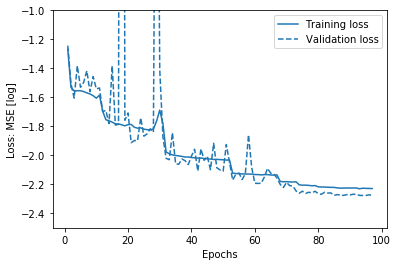

In [92]:
fig_history = plot_history( history_file, model_file, fig=None)
# fig_history.savefig( plot_file, bbox_inches='tight', format='pdf')
plt.ylim( -2.5, -1 )
fig_history.figsize = (20,20)
fig_history.show()
#plt.xlim(0,100)

#plt.semilogy()

In [100]:
Y = np.load(DataFilepath + "dev/" + "Y_0.1_tophat22_Z30_meanZ_database5_float32.npy")
print(Y.shape)

(20000, 4)


/media/yqin/81614149-2ed8-4c76-82e1-c46763d086fa/pregi/anaconda3/envs/21CNN_GPU_NEW/lib/python3.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
No handles with labels found to put in legend.


R2 ZETA:  0.978001905605197
plots/ZETA.pdf
249.9544677734375
number of points:  20000


No handles with labels found to put in legend.


R2 TVIR_MIN:  0.996367329498753
plots/TVIR_MIN.pdf
5.998933792114258
number of points:  20000


No handles with labels found to put in legend.


R2 L_X:  0.9840949177742004
plots/L_X.pdf
41.99989700317383
number of points:  20000


No handles with labels found to put in legend.


R2 NU_X_THRESH:  0.7471442222595215
plots/NU_X_THRESH.pdf
1499.37109375
number of points:  20000


<Figure size 1440x1440 with 0 Axes>

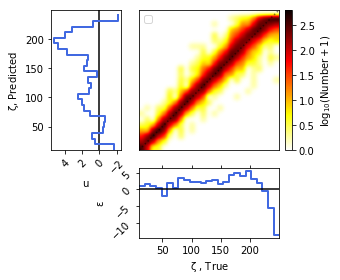

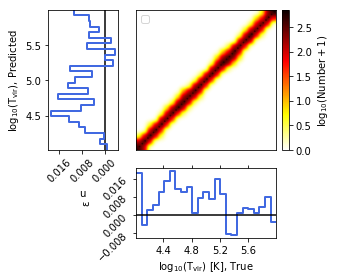

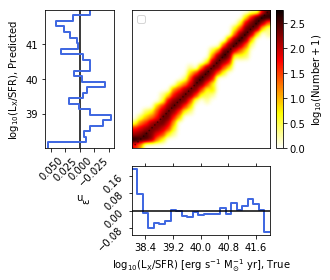

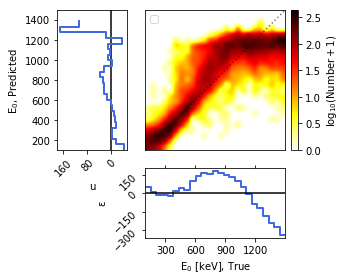

In [101]:
plt.figure(figsize=(20, 20))
bin_true, eps_mean, eps_std, u_mean, u_std = plot_result( prediction_file_val + ".npy", [0,1,2,3], 
                                                          Y, Ybackup, 
                                                          name='',
                                                          Nbin=25+1, 
                                                          save=False, Brad_pt=Brad_faint  ) # [0,1,2,3]

In [103]:
DataFilepathCNN = 'CNN/data_save/NGillet/tophat22_Z30_deeper_good/'
DataFilepath = "../data/"
### save files
model_file = DataFilepathCNN + "2D_Filter55_1batchNorm"
history_file = model_file + '_history'
prediction_file = model_file + '_pred'
prediction_file_val = model_file + '_pred_val'

Y = np.load(DataFilepath + "dev/" + "Y_0.1_tophat22_Z30_database5_float32.npy")
print(Y.shape)

model = load_model(model_file)
model.summary()

(20000, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
PreConv-1 (Conv2D)           (None, 46, 1049, 16)      416       
_________________________________________________________________
PreConv-2 (Conv2D)           (None, 42, 1045, 32)      12832     
_________________________________________________________________
PrePool-2 (MaxPooling2D)     (None, 21, 522, 32)       0         
_________________________________________________________________
Conv-1 (Conv2D)              (None, 17, 518, 32)       25632     
_________________________________________________________________
Conv-2 (Conv2D)              (None, 13, 514, 64)       51264     
_________________________________________________________________
Pool-2 (MaxPooling2D)        (None, 6, 257, 64)        0         
_________________________________________________________________
Conv-3 (Conv2D)              (None, 1, 252, 64)        147520    

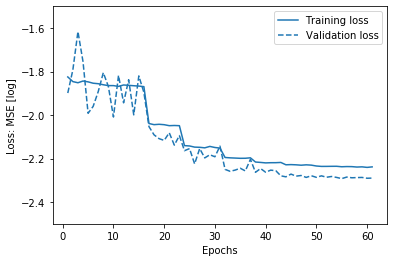

In [105]:
fig_history = plot_history( history_file, model_file, fig=None)
# fig_history.savefig( plot_file, bbox_inches='tight', format='pdf')
plt.ylim( -2.5, -1.5 )
fig_history.figsize = (20,20)
fig_history.show()

/media/yqin/81614149-2ed8-4c76-82e1-c46763d086fa/pregi/anaconda3/envs/21CNN_GPU_NEW/lib/python3.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
No handles with labels found to put in legend.


R2 ZETA:  0.9780173189938068
plots/ZETA.pdf
249.9544677734375
number of points:  20000


No handles with labels found to put in legend.


R2 TVIR_MIN:  0.9953041230328381
plots/TVIR_MIN.pdf
5.998933792114258
number of points:  20000


No handles with labels found to put in legend.


R2 L_X:  0.9841746967285872
plots/L_X.pdf
41.99989700317383
number of points:  20000


No handles with labels found to put in legend.


R2 NU_X_THRESH:  0.7650130242109299
plots/NU_X_THRESH.pdf
1499.37109375
number of points:  20000


<Figure size 1440x1440 with 0 Axes>

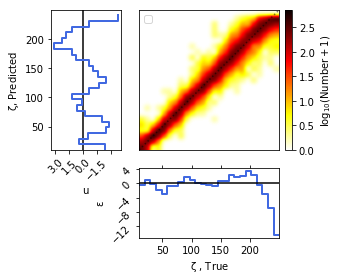

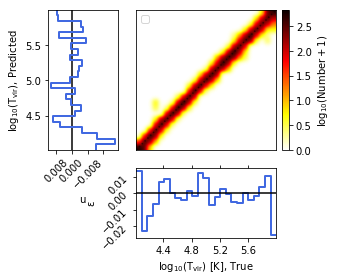

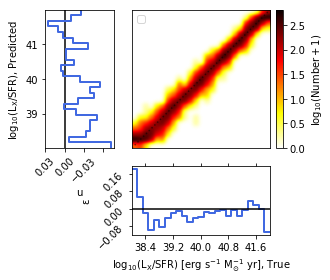

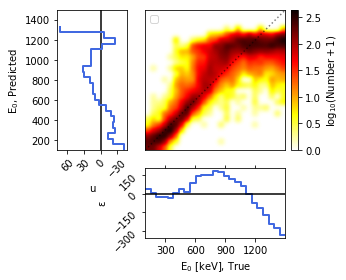

In [106]:
plt.figure(figsize=(20, 20))
bin_true, eps_mean, eps_std, u_mean, u_std = plot_result( prediction_file_val + ".npy", [0,1,2,3], 
                                                          Y, Ybackup, 
                                                          name='',
                                                          Nbin=25+1, 
                                                          save=False, Brad_pt=Brad_faint  ) # [0,1,2,3]

In [107]:
DataFilepathCNN = 'CNN/data_save/NGillet/tophat22_Z30_good/'
DataFilepath = "../data/"
### save files
model_file = DataFilepathCNN + "2D_Filter55_1batchNorm_WithMean_Z30_tophat22"
history_file = model_file + '_history'
prediction_file = model_file + '_pred'
prediction_file_val = model_file + '_pred_val'

Y = np.load(DataFilepath + "dev/" + "Y_0.1_tophat22_Z30_database5_float32.npy")
print(Y.shape)

model = load_model(model_file)
model.summary()

(20000, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv-1 (Conv2D)              (None, 46, 1049, 8)       208       
_________________________________________________________________
Pool-1 (MaxPooling2D)        (None, 23, 524, 8)        0         
_________________________________________________________________
Conv-2 (Conv2D)              (None, 19, 520, 16)       3216      
_________________________________________________________________
Flat (Flatten)               (None, 158080)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 158080)            0         
_________________________________________________________________
Dense-1 (Dense)              (None, 64)                10117184  
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       

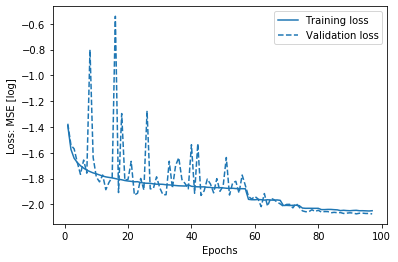

In [109]:
fig_history = plot_history( history_file, model_file, fig=None)
# fig_history.savefig( plot_file, bbox_inches='tight', format='pdf')
# plt.ylim( -2.5, -1.5 )
fig_history.figsize = (20,20)
fig_history.show()

No handles with labels found to put in legend.


R2 ZETA:  0.9314138516783714
plots/ZETA.pdf
249.9544677734375
number of points:  20000


No handles with labels found to put in legend.


R2 TVIR_MIN:  0.9916226929053664
plots/TVIR_MIN.pdf
5.998933792114258
number of points:  20000


No handles with labels found to put in legend.


R2 L_X:  0.9759729038923979
plots/L_X.pdf
41.99989700317383
number of points:  20000


/media/yqin/81614149-2ed8-4c76-82e1-c46763d086fa/pregi/anaconda3/envs/21CNN_GPU_NEW/lib/python3.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
No handles with labels found to put in legend.


R2 NU_X_THRESH:  0.5862472951412201
plots/NU_X_THRESH.pdf
1499.37109375
number of points:  20000


<Figure size 1440x1440 with 0 Axes>

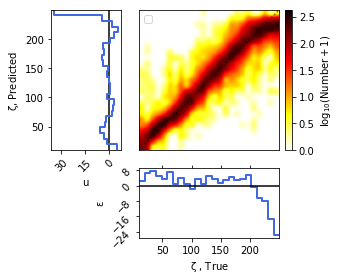

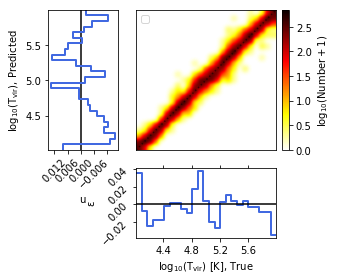

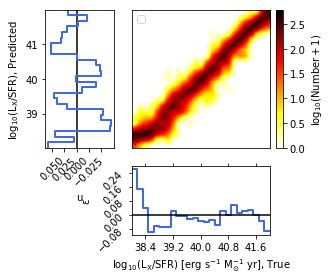

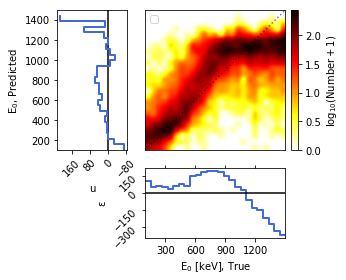

In [110]:
plt.figure(figsize=(20, 20))
bin_true, eps_mean, eps_std, u_mean, u_std = plot_result( prediction_file_val + ".npy", [0,1,2,3], 
                                                          Y, Ybackup, 
                                                          name='',
                                                          Nbin=25+1, 
                                                          save=False, Brad_pt=Brad_faint  ) # [0,1,2,3]